In [2]:
# This line configures matplotlib to show figures embedded in the notebook, 
# instead of opening a new window for each figure. More about that later. 
# If you are using an old version of IPython, try using '%pylab inline' instead.
%matplotlib inline
%load_ext ipycache
%precision 4
from ipy_table import make_table, apply_theme
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import scipy as sp
import pandas as pd
import networkx as nx
import networkxgmml
import tqdm

from sklearn import linear_model

sb.set_context('poster')
sb.set_style('white')
sb.set_color_codes()

seeds_file = "c_all.txt"
with open(seeds_file) as sf:
    genes = [line.strip() for line in sf.readlines()]

The ipycache extension is already loaded. To reload it, use:
  %reload_ext ipycache


In [3]:
import networkx as nx
net_file = "HINT_adjlist.txt"
G1 = nx.read_adjlist(net_file)
G1.remove_edges_from(G1.selfloop_edges())
## Find largest connected component
CC=sorted(nx.connected_components(G1), key = len, reverse=True)[0]
G1=G1.subgraph(CC)

In [4]:
import mygene
import itertools
mg = mygene.MyGeneInfo()
mygene_hits1 = mg.querymany([i for i in set(itertools.chain(genes, G1.nodes()))],
                           scopes="entrezgene", fields="symbol,alias")
from collections import defaultdict
symbols1 = defaultdict(list)
symbol_to_ez1 = {}
for h in mygene_hits1:
    ez = h['query']
    if h.get('notfound', False):
        symbols1[ ez ].append(ez)
        continue
    symbols1[ ez ].append(h.get('symbol', ez).upper())
    for a in h.get('alias', []):
        symbols1[ ez ].append(a.upper())
    for s in symbols1[ ez]:
        symbol_to_ez1[s] = ez

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-10662...done.
Finished.
29 input query terms found no hit:
	[u'378465', u'9503', u'6775098', u'90462', u'100271840', u'244', u'221016', u'102723367', u'439935',
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [5]:
def ppr(g, beta, nodelist=None):
    W = nx.to_numpy_matrix(g, nodelist=nodelist, dtype=np.float64 )
    W = np.asarray(W)
    W = W / W.sum(axis=1) # normalization step
    from scipy.linalg import inv
    n = len(g.nodes())
    PPR = beta*inv(sp.eye(n)-(1.-beta)*W)
    return PPR

In [7]:
beta = 0.4
G1_index2ezgene = dict((i,n) for i,n in enumerate(G1.nodes()))
G1_ezgene2index = dict((n,i) for i,n in G1_index2ezgene.items())
G1_gene_names = [symbols1[ez][0] for ez in G1.nodes()]
G1_index2gene = dict((i,symbols1[ez][0]) for i,ez in G1_index2ezgene.items())
G1_gene2index = dict((n,i) for i,n in G1_index2gene.items())
M1 = ppr(G1, beta)

In [8]:
def get_seeds_with_neighbors1(dataset):
    return {g: dict((G1_index2ezgene[i], n)
                                 for i, n in enumerate(M1[:,G1_ezgene2index[g]].tolist())
                                if G1_index2ezgene[i] in dataset.columns
                               )
                            for g in genes if g in dataset.columns and g in G1_ezgene2index}

In [11]:
gse45965 = pd.read_csv("gse45965.csv", index_col="sample")

In [26]:
gse45965_ctc_vs_bc = gse45965[(gse45965.group == 'CTC') | (gse45965.group == 'tissue: breast cancer tumor')]
gse45965_ctc_vs_pb = gse45965[(gse45965.group == 'CTC') | (gse45965.group == 'tissue: normal peripheral blood')]
gse45965_pb_vs_bc = gse45965[(gse45965.group == 'tissue: breast cancer tumor') | (gse45965.group == 'tissue: normal peripheral blood')]
gse45965_ctc_vs_bc_group = np.where(gse45965_ctc_vs_bc.group == 'CTC', 1, 0)
gse45965_ctc_vs_pb_group = np.where(gse45965_ctc_vs_pb.group == 'CTC', 1, 0)
gse45965_pb_vs_bc_group = np.where(gse45965_pb_vs_bc.group == 'tissue: breast cancer tumor', 1, 0)

In [37]:
%run subnet_stacking.py
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn import linear_model
from sklearn import tree
from sklearn import neighbors
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.ensemble import RandomForestClassifier


g27_clf = Pipeline([('subset_g27', GeneSubsetTransformer(features=[g for g in genes if g in gse45965.columns])),
                   ('logreg', linear_model.LogisticRegression())])

all_clfs = [linear_model.LogisticRegression(), 
            neighbors.KNeighborsClassifier(n_neighbors=5), 
            RandomForestClassifier(),
            svm.SVC(kernel="rbf", C=1),
            svm.SVC(kernel="linear", C=1),
            g27_clf,
            SubnetStackingClassifier(seeds_with_neighbors=get_seeds_with_neighbors1(gse45965.drop("group",1)))
           ]

#### CTC versus Breast Cancer

In [38]:
#%run subnet_stacking.py
#from sklearn.pipeline import Pipeline
#g27_clf = Pipeline([('subset_g27', GeneSubsetTransformer(features=[g for g in genes if g in gse45965.columns])),
#                   ('logreg', linear_model.LogisticRegression())])
#clfs = [linear_model.LogisticRegression(), g27_clf, 
#        SubnetStackingClassifier(seeds_with_neighbors=get_seeds_with_neighbors1(gse45965_ctc_vs_pb.drop("group",1)))]
scores_ctc_vs_pb, fitted_clfs_ctc_vs_pb = score_clfs_in_df_parallel(all_clfs, 
                                                                    gse45965_ctc_vs_pb.drop("group",1), 
                                                                    gse45965_ctc_vs_pb_group,
                                                                    n_iter = 100, n_jobs=20)

[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:   32.4s
[Parallel(n_jobs=20)]: Done   2 tasks      | elapsed:   38.3s
[Parallel(n_jobs=20)]: Done   3 tasks      | elapsed:   43.7s
[Parallel(n_jobs=20)]: Done   4 tasks      | elapsed:   50.3s
[Parallel(n_jobs=20)]: Done   5 tasks      | elapsed:   55.7s
[Parallel(n_jobs=20)]: Done   6 tasks      | elapsed:  1.0min
[Parallel(n_jobs=20)]: Done   7 tasks      | elapsed:  1.1min
[Parallel(n_jobs=20)]: Done   8 tasks      | elapsed:  1.2min
[Parallel(n_jobs=20)]: Done   9 tasks      | elapsed:  1.3min
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:  1.4min
[Parallel(n_jobs=20)]: Done  11 tasks      | elapsed:  1.5min
[Parallel(n_jobs=20)]: Done  12 tasks      | elapsed:  1.6min
[Parallel(n_jobs=20)]: Done  13 tasks      | elapsed:  1.7min
[Parallel(n_jobs=20)]: Done  14 tasks      | elapsed:  1.8min
[Parallel(n_jobs=20)]: Done  15 tasks      | elapsed:  1.9min
[Parallel(n_jobs=20)]: Done  16 tasks      | elapsed:  2.0min
[Paralle

In [40]:
np.mean(np.stack(s["roc_auc"] for s in scores_ctc_vs_pb), axis=0)

array([ 0.99  ,  0.95  ,  0.83  ,  0.98  ,  0.99  ,  0.9325,  0.955 ])

#### CTC versus peripheral blood

In [39]:
scores_ctc_vs_pb, fitted_clfs_ctc_vs_pb = score_clfs_in_df_parallel(all_clfs,
                                                         gse45965_ctc_vs_pb.drop("group",1), 
                                                        gse45965_ctc_vs_pb_group,
                                                        n_iter = 100, n_jobs=10)

[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:   33.0s
[Parallel(n_jobs=10)]: Done   2 tasks      | elapsed:   38.8s
[Parallel(n_jobs=10)]: Done   3 tasks      | elapsed:   44.2s
[Parallel(n_jobs=10)]: Done   4 tasks      | elapsed:   50.4s
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:   56.9s
[Parallel(n_jobs=10)]: Done   6 tasks      | elapsed:  1.0min
[Parallel(n_jobs=10)]: Done   7 tasks      | elapsed:  1.2min
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:  1.3min
[Parallel(n_jobs=10)]: Done   9 tasks      | elapsed:  1.4min
[Parallel(n_jobs=10)]: Done  10 tasks      | elapsed:  1.5min
[Parallel(n_jobs=10)]: Done  11 tasks      | elapsed:  1.6min
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:  1.7min
[Parallel(n_jobs=10)]: Done  13 tasks      | elapsed:  1.8min
[Parallel(n_jobs=10)]: Done  14 tasks      | elapsed:  1.9min
[Parallel(n_jobs=10)]: Done  15 tasks      | elapsed:  2.0min
[Parallel(n_jobs=10)]: Done  16 tasks      | elapsed:  2.1min
[Paralle

In [77]:
pd.DataFrame({"Classifier": [str_clf(c) for c in all_clfs],
              "ROC AUC": np.mean(np.stack(s["roc_auc"] for s in scores_ctc_vs_pb), axis=0),
              "F1": np.mean(np.stack(s["f1"] for s in scores_ctc_vs_pb), axis=0),
              "Precision": np.mean(np.stack(s["precision"] for s in scores_ctc_vs_pb), axis=0),
              "Recall": np.mean(np.stack(s["recall"] for s in scores_ctc_vs_pb), axis=0),
              "Matthews corr. coef.": np.mean(np.stack(s["matthews_corrcoef"] for s in scores_ctc_vs_pb), axis=0)})

,Classifier,F1,Matthews corr. coef.,Precision,ROC AUC,Recall
0,LogisticRegression,0.992000,0.983094,0.986667,0.9900,1.000
1,KNeighborsClassifier,0.936000,0.915470,0.993333,0.9500,0.910
2,RandomForestClassifier,0.744333,0.684752,0.795000,0.8300,0.735
3,SVC,0.982667,0.966188,0.976667,0.9800,0.995
4,SVC,0.992000,0.983094,0.986667,0.9900,1.000
5,Pipeline,0.910000,0.885885,1.000000,0.9325,0.865
6,SubnetStackingClassifier,0.954667,0.923923,0.963333,0.9550,0.965


#### Peripheral Blood versus Breast Cancer

In [42]:
scores_pb_vs_bc, fitted_clfs_pb_vs_bc = score_clfs_in_df_parallel(all_clfs,
                                                         gse45965_pb_vs_bc.drop("group",1), 
                                                        gse45965_pb_vs_bc_group,
                                                        n_iter = 100, n_jobs=10, verbose=False)

In [78]:
pd.DataFrame({"Classifier": [str_clf(c) for c in all_clfs],
              "ROC AUC": np.mean(np.stack(s["roc_auc"] for s in scores_pb_vs_bc), axis=0),
              "F1": np.mean(np.stack(s["f1"] for s in scores_pb_vs_bc), axis=0),
              "Precision": np.mean(np.stack(s["precision"] for s in scores_pb_vs_bc), axis=0),
              "Recall": np.mean(np.stack(s["recall"] for s in scores_pb_vs_bc), axis=0),
              "Matthews corr. coef.": np.mean(np.stack(s["matthews_corrcoef"] for s in scores_pb_vs_bc), axis=0)})

,Classifier,F1,Matthews corr. coef.,Precision,ROC AUC,Recall
0,LogisticRegression,0.998688,0.992426,1.000000,0.998750,0.997500
1,KNeighborsClassifier,0.992121,0.918359,0.984706,0.935000,1.000000
2,RandomForestClassifier,0.989639,0.895985,0.981728,0.921562,0.998125
3,SVC,0.994242,0.940339,0.988824,0.952500,1.000000
4,SVC,0.999697,0.996860,0.999412,0.997500,1.000000
5,Pipeline,0.992033,0.951810,0.996434,0.979375,0.988750
6,SubnetStackingClassifier,0.989722,0.923239,0.990515,0.955000,0.990000


Let's see what are the accumulated feature importances computed by the plain Random Forest classifier. (This classifier is in the 3rd position (i.e. in 2) in our lists of classifiers). The following computes the set of genes that have non-zero feature importance in any of the 100 splits of the PB vs BC comparison:

In [368]:
rf_fimp_pb_vs_bc = set([x for i in range(100) for x in (fitted_clfs_pb_vs_bc[i][2].feature_importances_ > 0.0).nonzero()[0]])
len(rf_fimp_pb_vs_bc)

455

The same for the CTC vs PB comparison:

In [373]:
rf_fimp_ctc_vs_pb = set([x for i in range(100) for x in (fitted_clfs_ctc_vs_pb[i][2].feature_importances_ > 0.0).nonzero()[0]])
len(rf_fimp_ctc_vs_pb)

306

OK, so let's keep only the most important genes and then run the same evaluation again for the different classifiers:

In [370]:
all_clfs2 = [linear_model.LogisticRegression(), 
            neighbors.KNeighborsClassifier(n_neighbors=5), 
            RandomForestClassifier(),
            svm.SVC(kernel="rbf", C=1),
            svm.SVC(kernel="linear", C=1)]

srf, _ = score_clfs_in_df_parallel(all_clfs2,
                                   gse45965_pb_vs_bc.drop("group",1).ix[:, rf_fimp_pb_vs_bc],
                                   gse45965_pb_vs_bc_group,
                                   n_iter = 100, n_jobs=10)

[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Batch computation too fast (0.1239s.) Setting batch_size=2.
[Parallel(n_jobs=10)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done   6 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done   7 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done  10 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done  11 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done  13 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done  14 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done  15 tasks      | elap

In [372]:
pd.DataFrame({"Classifier": [str_clf(c) for c in all_clfs2],
              "ROC AUC": np.mean(np.stack(s["roc_auc"] for s in srf), axis=0),
              "F1": np.mean(np.stack(s["f1"] for s in srf), axis=0),
              "Precision": np.mean(np.stack(s["precision"] for s in srf), axis=0),
              "Recall": np.mean(np.stack(s["recall"] for s in srf), axis=0),
              "Matthews corr. coef.": np.mean(np.stack(s["matthews_corrcoef"] for s in srf), axis=0)})

,Classifier,F1,Matthews corr. coef.,Precision,ROC AUC,Recall
0,LogisticRegression,1.000000,1.000000,1.000000,1.000000,1.00000
1,KNeighborsClassifier,1.000000,1.000000,1.000000,1.000000,1.00000
2,RandomForestClassifier,0.990545,0.905553,0.982941,0.926875,0.99875
3,SVC,0.999394,0.993720,0.998824,0.995000,1.00000
4,SVC,1.000000,1.000000,1.000000,1.000000,1.00000


#### CTC vs PB

In [374]:
srf, _ = score_clfs_in_df_parallel(all_clfs2,
                                   gse45965_ctc_vs_pb.drop("group",1).ix[:, rf_fimp_ctc_vs_pb],
                                   gse45965_ctc_vs_pb_group,
                                   n_iter = 100, n_jobs=10)

[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Batch computation too fast (0.1294s.) Setting batch_size=2.
[Parallel(n_jobs=10)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done   6 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done   7 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done  10 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done  11 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done  13 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done  14 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done  15 tasks      | elap

In [376]:
pd.DataFrame({"Classifier": [str_clf(c) for c in all_clfs2],
              "ROC AUC": np.mean(np.stack(s["roc_auc"] for s in srf), axis=0),
              "F1": np.mean(np.stack(s["f1"] for s in srf), axis=0),
              "Precision": np.mean(np.stack(s["precision"] for s in srf), axis=0),
              "Recall": np.mean(np.stack(s["recall"] for s in srf), axis=0),
              "Matthews corr. coef.": np.mean(np.stack(s["matthews_corrcoef"] for s in srf), axis=0)})

,Classifier,F1,Matthews corr. coef.,Precision,ROC AUC,Recall
0,LogisticRegression,0.996000,0.991547,0.993333,0.995,1.000
1,KNeighborsClassifier,0.962667,0.949282,0.993333,0.970,0.950
2,RandomForestClassifier,0.832667,0.794752,0.906667,0.885,0.805
3,SVC,0.996000,0.991547,0.993333,0.995,1.000
4,SVC,0.996000,0.991547,0.993333,0.995,1.000


## Check subnetworks and their "importance"

We compute the "feature importances" for the SubnetStackingClassifier's 2nd level classifier (which is a Random Forest) for each of the 100 runs in both comparisons:

In [214]:
def compute_imp(fitted, scores, normalize_per_neighbors_nbr=False):
    def d(clf):
        c = clf.meta_clf_.feature_importances_ * score.roc_auc[-1]
        if normalize_per_neighbors_nbr:
            c /= [len(s.get_nearest_neighbors()) for s in clf.base_clfs_]
        return c
    return pd.DataFrame([d(clfs[-1]) for clfs, score in zip(fitted, scores)],
                        columns=[symbols1[c.seed][0] for c in fitted[0][-1].base_clfs_])

imp_ctc_vs_pb = compute_imp(fitted_clfs_ctc_vs_pb, scores_ctc_vs_pb)
imp_pb_vs_bc = compute_imp(fitted_clfs_pb_vs_bc, scores_pb_vs_bc)

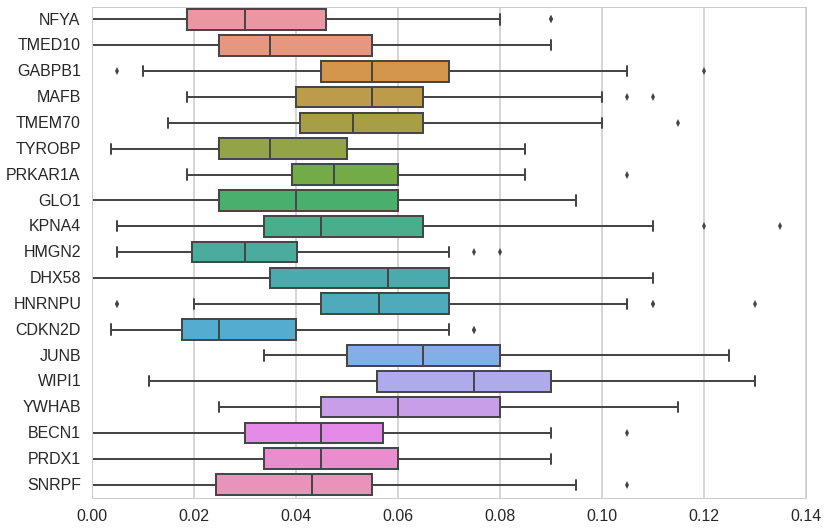

In [223]:
sb.set_style("whitegrid")
sb.boxplot(data=imp_ctc_vs_pb, orient="h", linewidth=2)
plt.show()

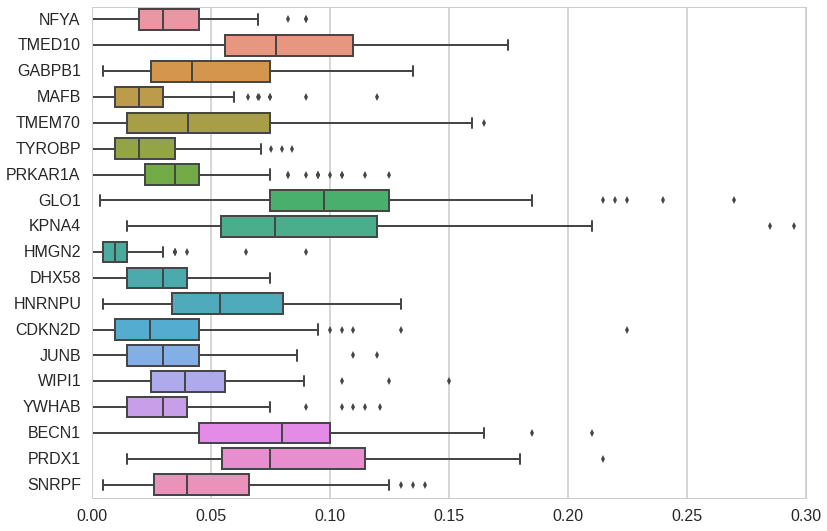

In [224]:
sb.boxplot(data=imp_pb_vs_bc, orient="h", linewidth=2)
plt.show()

Each of the feature in the 2nd level classifier is a base classifier built around a "seed" gene. The following shows the mean feature importance for each base classifier in the CTC-vs-Peripheral Blood comparison:

In [225]:
pd.DataFrame({"Median importance": imp_ctc_vs_pb.mean(axis=0), "Std": imp_ctc_vs_pb.std(axis=0)}, index=imp_ctc_vs_pb.columns)

,Median importance,Std
NFYA,0.033362,0.020426
TMED10,0.040125,0.021431
GABPB1,0.057300,0.021238
MAFB,0.055263,0.019656
TMEM70,0.055112,0.019510
TYROBP,0.037762,0.019280
PRKAR1A,0.049975,0.017379
GLO1,0.040837,0.020929
KPNA4,0.049537,0.024241
HMGN2,0.030875,0.016278


And therefore the most important "feature" is the one with the largest mean importance:

In [226]:
imp_ctc_vs_pb.mean(axis=0).argmax()

u'WIPI1'

The following are the mean feature importances for the Perpheral Blood versus Breast Cancer:

In [227]:
pd.DataFrame({"Mean importance": imp_pb_vs_bc.mean(axis=0), "Std": imp_pb_vs_bc.std(axis=0)}, index=imp_pb_vs_bc.columns)

,Mean importance,Std
NFYA,0.033873,0.018404
TMED10,0.084089,0.039118
GABPB1,0.053005,0.033281
MAFB,0.023664,0.021316
TMEM70,0.048428,0.040155
TYROBP,0.023645,0.019769
PRKAR1A,0.039700,0.025996
GLO1,0.104306,0.047899
KPNA4,0.089678,0.051703
HMGN2,0.012427,0.013532


In this case the most important "feature" is the one with the largest mean importance:

In [228]:
imp_pb_vs_bc.mean(axis=0).argmax()

u'GLO1'

Putting the two comparisons together:

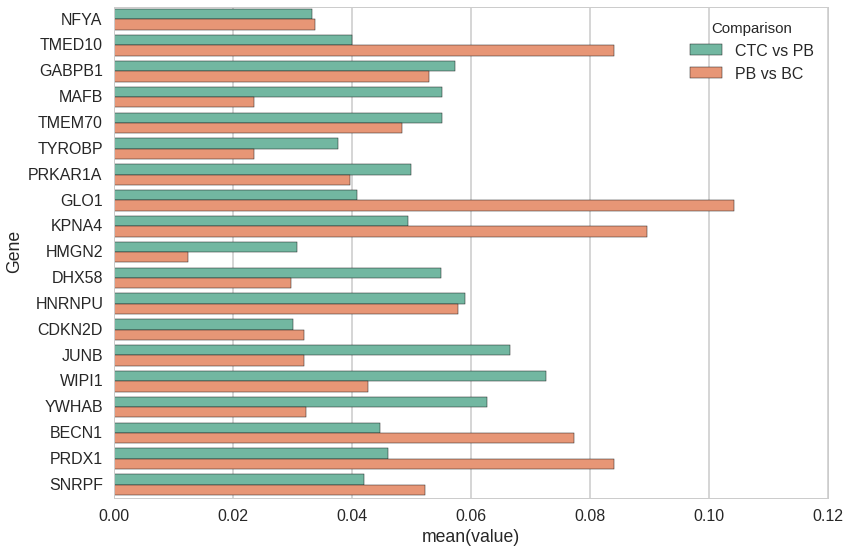

In [229]:
a = pd.DataFrame({"PB vs BC": imp_pb_vs_bc.mean(axis=0), "CTC vs PB": imp_ctc_vs_pb.mean(axis=0),
                 "Gene":imp_ctc_vs_pb.columns})
a = pd.melt(a, id_vars=["Gene"], var_name="Comparison")
sb.barplot(y="Gene", x="value", hue="Comparison", data=a, palette="Set2")
plt.show()

In [350]:
sc = fitted_clfs_ctc_vs_pb[0][-1]
sc.base_clfs_[0].get_nearest_neighbors()

[u'10513',
 u'11244',
 u'4800',
 u'4801',
 u'6667',
 u'6721',
 u'1457',
 u'4802',
 u'51631',
 u'993']

In [351]:
sc.meta_clf_.feature_importances_

array([ 0.035,  0.02 ,  0.07 ,  0.11 ,  0.065,  0.02 ,  0.05 ,  0.03 ,
        0.05 ,  0.04 ,  0.065,  0.07 ,  0.02 ,  0.085,  0.075,  0.08 ,
        0.025,  0.03 ,  0.035])

In [352]:
[len(s.get_nearest_neighbors()) for s in sc.base_clfs_]

[10, 10, 20, 20, 3, 3, 3, 20, 5, 3, 10, 3, 5, 5, 10, 3, 5, 5, 5]

In [353]:
sc.meta_clf_.feature_importances_ / [len(s.get_nearest_neighbors()) for s in sc.base_clfs_]

array([ 0.0035,  0.002 ,  0.0035,  0.0055,  0.0217,  0.0067,  0.0167,
        0.0015,  0.01  ,  0.0133,  0.0065,  0.0233,  0.004 ,  0.017 ,
        0.0075,  0.0267,  0.005 ,  0.006 ,  0.007 ])

In [317]:
subnets=defaultdict(list)
for fc in fitted_clfs_ctc_vs_pb:
    for b in fc[-1].base_clfs_:
        subnets[b.seed].extend ( b.get_nearest_neighbors() )
subnets_stats={k: defaultdict(int) for k in subnets.keys()}
for s, v in subnets.iteritems():
    for a in v:
        subnets_stats[s][a] += 1

threshold = 60
for s, v in subnets_stats.iteritems():
    l = [n for n,c in v.items() if c > threshold]
    print "%s %d: %s" % (symbols1[s][0], len(l), ", ".join(sorted([symbols1[g][0] for g in l])))


NFYA 10: APPBP2, CDC25A, CSNK2A1, LUC7L2, NFYA, NFYB, NFYC, SP1, SREBF2, ZHX1
TMED10 10: AKT1, AKT2, APOB, ASS1, DHODH, JMJD1C, RCHY1, SNX27, TMED10, TMED2
GABPB1 10: CIC, FANCG, GABPA, GABPB1, IL16, LMO4, RSPH14, SNRPB2, TRAF2, USO1
MAFB 20: ANAPC5, ATF1, ATF2, ATF4, BECN1, CEBPG, CREB5, DDB1, FOS, FOSL1, FOSL2, JUN, JUNB, JUND, MAFB, MAFG, MIS12, ZDHHC2, ZW10, ZWINT
TMEM70 3: PHC2, SSX2IP, TMEM70
TYROBP 3: MEOX2, MICA, TYROBP
PRKAR1A 3: PRKAR1A, UBE2I, WNK1
GLO1 20: BCL10, BIRC2, CDCA8, CREBBP, EEF1A1, GIT2, GLO1, GTF2E1, IKBKB, IRAK1, NFKBIA, RIPK1, STAT3, SUPT5H, TANK, TAX1BP1, TNFAIP3, TNIP1, TRIM29, ZDHHC17
KPNA4 5: HNRNPC, KPNA3, KPNA4, MAT2B, RAC1
HMGN2 10: APEX1, EP300, GRB2, HMGN2, NCK1, TERF1, TERF2, TERF2IP, TINF2, XRCC6
DHX58 10: ACVR1, APC, DHX58, ITSN1, KPNA2, MLH1, POM121, SMAD4, SMURF1, TERF2IP
HNRNPU 10: A1CF, CDKN2A, HNRNPD, HNRNPF, HNRNPH3, HNRNPU, MAPK6, PRMT1, RBM4, SYNCRIP
CDKN2D 20: ASCC2, ATXN1, CDK4, CDK6, CDKN2D, COPS5, DAB1, GRB2, HSD17B14, IKZF3, INCA1, NEK

In [310]:
a = pd.DataFrame({"seed": [symbols1[s][0] for s, v in subnets_stats.iteritems() for n,c in v.items() if c > threshold],
             "neighbor":[symbols1[n][0] for s, v in subnets_stats.iteritems() for n,c in v.items() if c > threshold]})
b = a.groupby("neighbor",as_index=False).count()
in_multiple_subnets = b[b.seed>1].neighbor

a[a.neighbor.isin(in_multiple_subnets)].sort_values(by="neighbor")

,neighbor,seed
48,ATF2,MAFB
134,ATF2,JUNB
141,ATXN1,WIPI1
131,ATXN1,CDKN2D
35,BECN1,MAFB
153,BECN1,BECN1
42,CREB5,MAFB
135,CREB5,JUNB
86,GRB2,HMGN2
117,GRB2,CDKN2D


In [315]:
subnets=defaultdict(list)
for fc in fitted_clfs_pb_vs_bc:
    for b in fc[-1].base_clfs_:
        subnets[b.seed].extend ( b.get_nearest_neighbors() )
subnets_stats={k: defaultdict(int) for k in subnets.keys()}
for s, v in subnets.iteritems():
    for a in v:
        subnets_stats[s][a] += 1

threshold = 60
for s, v in subnets_stats.iteritems():
    l = [n for n,c in v.items() if c > threshold]
    print "%s %d : %s" % (symbols1[s][0], len(l), ", ".join(sorted([symbols1[g][0] for g in l])))


NFYA 20 : APPBP2, CDC25A, CREB1, CSNK2A1, ESR2, GRB2, GTF2A2, GTF2E2, LUC7L2, NFYA, NFYB, NFYC, PAPOLG, PCBD1, PWP1, SMURF1, SP1, SREBF2, TBP, ZHX1
TMED10 21 : AKT1, AKT1S1, AKT2, APOA1, APOB, ASS1, DHODH, ESR1, JMJD1C, NAMPT, PDPK1, POFUT1, PRKDC, RCHY1, SH3RF1, SNX27, SORBS2, STEAP4, TCL1A, TMED10, TMED2
GABPB1 20 : ATXN1, ATXN2, CDKN2A, CIC, CSNK2B, DAZAP2, FANCG, GABPA, GABPB1, IL16, LMO4, MTUS2, PCBP1, QKI, RSPH14, SNRPB2, TRAF2, TRIM27, USHBP1, USO1
MAFB 20 : ANAPC5, ATF1, ATF2, ATF4, BECN1, CEBPG, CREB5, DDB1, FOS, FOSL1, FOSL2, JUN, JUNB, JUND, MAFB, MAFG, MIS12, ZDHHC2, ZW10, ZWINT
TMEM70 20 : BMI1, BYSL, CSNK2B, FAM161A, FHL3, GFI1B, GRB2, KAT5, KDM1A, KIFC3, L3MBTL3, MAPK6, MFAP1, NCK1, PHC2, SIAH1, SMAD3, SSX2IP, TMEM70, TRIM41
TYROBP 10 : ATXN1, DAB1, DAZAP2, KLRK1, MDFI, MEOX2, MICA, RBFOX2, RBPMS, TYROBP
PRKAR1A 5 : MAPK6, PRKAR1A, TAB1, UBE2I, WNK1
GLO1 30 : BCL10, BIRC2, CDCA8, CLIC1, CREBBP, EEF1A1, GCC1, GIT2, GLO1, GTF2E1, IKBKB, IRAK1, KRT18, NFKBIA, POLR2E, PPP2CA

In [314]:
a = pd.DataFrame({"seed": [symbols1[s][0] for s, v in subnets_stats.iteritems() for n,c in v.items() if c > threshold],
             "neighbor":[symbols1[n][0] for s, v in subnets_stats.iteritems() for n,c in v.items() if c > threshold]})
b = a.groupby("neighbor",as_index=False).count()
in_multiple_subnets = b[b.seed>1].neighbor

a[a.neighbor.isin(in_multiple_subnets)].sort_values(by="neighbor")

,neighbor,seed
79,ATF2,MAFB
245,ATF2,JUNB
70,ATF4,MAFB
241,ATF4,JUNB
238,ATXN1,CDKN2D
110,ATXN1,TYROBP
56,ATXN1,GABPB1
252,ATXN1,WIPI1
268,BAD,BECN1
256,BAD,YWHAB


In [81]:
pd.DataFrame({"Classifier": [str_clf(c) for c in [linear_model.LogisticRegression(), neighbors.KNeighborsClassifier(n_neighbors=5), 
                               RandomForestClassifier(), svm.SVC(kernel="rbf", C=1), svm.SVC(kernel="linear", C=1)]], 
              "ROC AUC": np.mean(np.stack(s["roc_auc"] for s in scores_1), axis=0)})

,Classifier,ROC AUC
0,LogisticRegression,0.9900
1,KNeighborsClassifier,0.9500
2,RandomForestClassifier,0.7875
3,SVC,0.9800
4,SVC,0.9900


In [261]:
more_clfs = [linear_model.LogisticRegression(), 
                                neighbors.KNeighborsClassifier(n_neighbors=5), 
                                RandomForestClassifier(), 
                                svm.SVC(kernel="rbf", C=1), 
                                svm.SVC(kernel="linear", C=1)]
scores_2, _ = score_clfs_in_df(more_clfs,
                               gse45965_pb_vs_bc.drop("group",1), 
                                                        gse45965_pb_vs_bc_group,
                                                        n_iter = 100, verbose=False)

In [262]:
pd.DataFrame({"Classifier": [str_clf(c) for c in more_clfs], 
              "ROC AUC": np.mean(np.stack(s["roc_auc"] for s in scores_2), axis=0)})

,Classifier,ROC AUC
0,LogisticRegression,0.701250
1,KNeighborsClassifier,0.859062
2,RandomForestClassifier,0.841875
3,SVC,0.822500
4,SVC,0.953438


In [263]:
all_clfs = [linear_model.LogisticRegression(), 
                                neighbors.KNeighborsClassifier(n_neighbors=5), 
                                RandomForestClassifier(), 
                                svm.SVC(kernel="rbf", C=1), 
                                svm.SVC(kernel="linear", C=1),
             g27_clf, 
            SubnetStackingClassifier(seeds_with_neighbors=get_seeds_with_neighbors1(gse45965_ctc_vs_pb.drop("group",1)))
            ]

In [ ]:
import sklearn.cross_validation
random_state = np.random.RandomState(0xBABE)
cvs = [cross_validation.StratifiedKFold(gse45965_pb_vs_bc_group, n_folds=3, random_state=random_state)
       for _ in range(500)]

In [ ]:
pps = []
for cv in cvs:
    p = [(c, sklearn.cross_validation.cross_val_score(c,
                                         gse45965_pb_vs_bc.drop("group", 1),
                                         gse45965_pb_vs_bc_group, cv=cv, scoring="roc_auc"))
         for c in all_clfs]
    pps.append( p)

In [ ]:

pd.DataFrame({"AUC": [v*1.0/len(pps) for c,v in st.iteritems()]}, index=[str_clf(c) for c in st.keys()])

## Repeated CV
We are going to test the Subnet Stackign classisifier with repeated cross validation (See: Ji-Hyun Kim, "Estimating classification error rate: Repeated cross-validation, repeated hold-out and bootstrap, Computational Statistics & Data Analysis, Vol 53(11), http://dx.doi.org/10.1016/j.csda.2009.04.009))


In [279]:
all_clfs = {"Logistic Regression": linear_model.LogisticRegression(), 
            "K-nearest Neighbors(k=5)": neighbors.KNeighborsClassifier(n_neighbors=5), 
            "Random Forrest": RandomForestClassifier(), 
            "SVM-RBF": svm.SVC(kernel="rbf", C=1), 
             "SVM-Linear": svm.SVC(kernel="linear", C=1),
             "Log. regression (G27)": g27_clf, 
            "Subnet Stacking": SubnetStackingClassifier(seeds_with_neighbors=get_seeds_with_neighbors1(gse45965.drop("group",1)))
            }
n_iter = 100
n_jobs = 20

We are going to use 100 iterations in parallel (20 processes) of 3-fold cross validation, which means 300 training and testing sets..

#### CTC versus Peripheral Blood

In [280]:
from sklearn import cross_validation
random_state = np.random.RandomState(0xCAFE)
cvs_ctc_vs_pb = [cross_validation.StratifiedKFold(gse45965_ctc_vs_pb_group, n_folds=3, 
                                                  shuffle=True, random_state=random_state)
                 for _ in range(n_iter)]

How many distinct testing sets we have?

In [281]:
from collections import defaultdict
st=defaultdict(int)
def str_set(s): return ":".join(str(k) for k in s)
for cv in cvs_ctc_vs_pb:
    for train,test in cv:
        st[ str_set(set(test)) ] += 1
print len(st.keys())


232


In [282]:
def parallel_cv(cv, all_clfs, X, y):
    import sklearn.cross_validation
    p = {n : sklearn.cross_validation.cross_val_score(c, X,y, cv=cv, scoring="roc_auc")
         for n, c in all_clfs.items()}
    return p

Start the Cross Validations.. This takes a lot of time!!

In [283]:
from joblib import Parallel, delayed
scores_ctc_vs_pb = Parallel(n_jobs=n_jobs)(delayed(parallel_cv)(cv, all_clfs, 
                                                gse45965_ctc_vs_pb.drop("group",1), 
                                                gse45965_ctc_vs_pb_group)
                           for cv in cvs_ctc_vs_pb)

In [284]:
from collections import defaultdict
st=defaultdict(int)
for pp in scores_ctc_vs_pb:
    for n, s in pp.items():
        st[n] += np.mean(s)
pd.DataFrame({"AUC": [v*1.0/n_iter for c,v in st.iteritems()],
              "std. dev": [np.std(v) for c,v in st.iteritems()]},
             index=[c for c,v in st.iteritems()])


,AUC,std. dev
SVM-Linear,1.000000,0
Logistic Regression,1.000000,0
Log. regression (G27),1.000000,0
Random Forrest,0.961944,0
SVM-RBF,1.000000,0
Subnet Stacking,1.000000,0
K-nearest Neighbors(k=5),0.985278,0


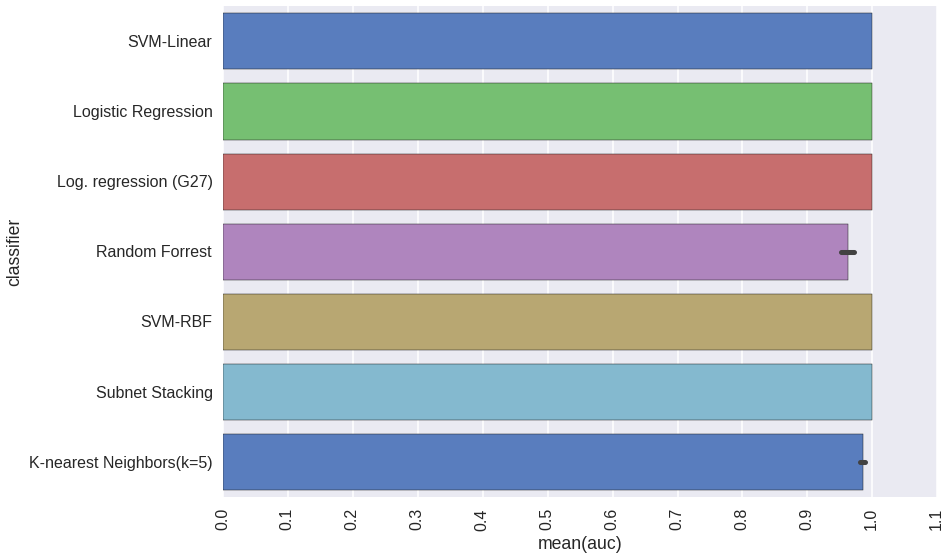

In [285]:
st=[]
for pp in scores_ctc_vs_pb:
    for n, s in pp.items():
        st.append( (n, np.mean(s)) )
a = pd.DataFrame({'classifier': [v[0] for v in st], 'auc': [v[1] for v in st]})
sb.set_style("darkgrid")
sb.barplot(y="classifier", x="auc", data=a, palette="muted")
plt.xticks(np.arange(0,1.12,0.1), rotation=90)
plt.show()

#### Peripheral Blood vs Breast Cancer

In [286]:
random_state = np.random.RandomState(0xCAFE)
cvs_pb_vs_bc = [cross_validation.StratifiedKFold(gse45965_pb_vs_bc_group, n_folds=3, 
                                                  shuffle=True, random_state=random_state)
                 for _ in range(n_iter)]

How many distinct testing sets we have?

In [287]:
from collections import defaultdict
st=defaultdict(int)
def str_set(s): return ":".join(str(k) for k in s)
for cv in cvs_pb_vs_bc:
    for train,test in cv:
        st[ str_set(set(test)) ] += 1
print len(st.keys())

300


In [288]:
from joblib import Parallel, delayed
scores_pb_vs_bc = Parallel(n_jobs=n_jobs, verbose=5)(delayed(parallel_cv)(cv, all_clfs, 
                                                gse45965_pb_vs_bc.drop("group",1), 
                                                gse45965_pb_vs_bc_group)
                           for cv in cvs_pb_vs_bc)


[Parallel(n_jobs=20)]: Done  32 tasks      | elapsed:  7.5min
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed: 18.2min finished


In [289]:
from collections import defaultdict
st=defaultdict(list)
for pp in scores_pb_vs_bc:
    for n, s in pp.items():
        st[n].append(np.mean(s))
pd.DataFrame({"Avg. AUC": [np.mean(v) for c,v in st.iteritems()],
              "std. dev": [np.std(v) for c,v in st.iteritems()]}
             , index=[c for c,v in st.iteritems()])


,Avg. AUC,std. dev
SVM-Linear,0.998550,0.004582
Logistic Regression,0.849855,0.046502
Log. regression (G27),0.999112,0.003377
Random Forrest,0.973131,0.028785
SVM-RBF,0.997911,0.004831
Subnet Stacking,0.995901,0.007600
K-nearest Neighbors(k=5),0.965956,0.027296


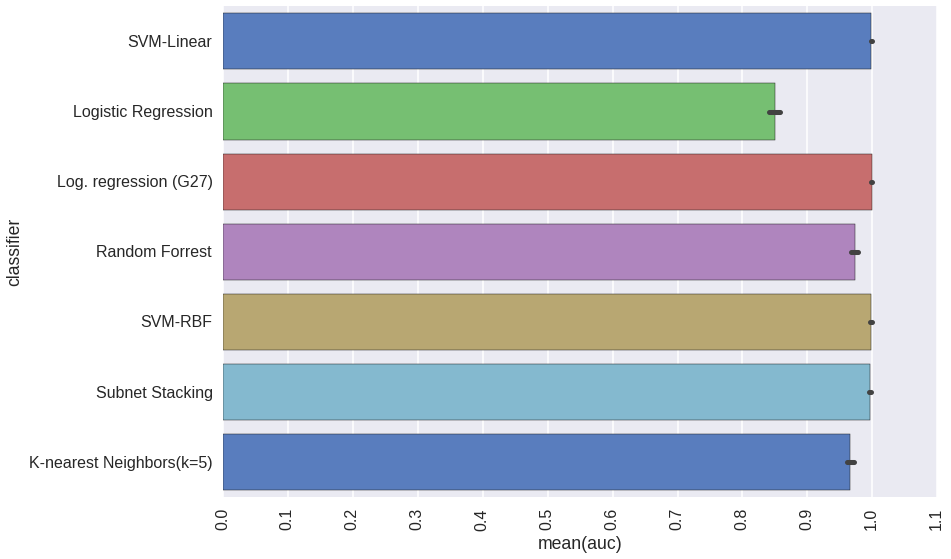

In [290]:
st=[]
for pp in scores_pb_vs_bc:
    for n, s in pp.items():
        st.append( (n, np.mean(s)) )
a = pd.DataFrame({'classifier': [v[0] for v in st], 'auc': [v[1] for v in st]})
sb.set_style("darkgrid")
sb.barplot(y="classifier", x="auc", data=a, palette="muted")
plt.xticks(np.arange(0,1.12,0.1), rotation=90)
plt.show()